# Fiber Design

**Scott Prahl**

**Mar 2021**

---
*If* `` ofiber `` *is not installed, uncomment the following cell (i.e., delete the initial #) and execute it with* `` shift-enter ``.  *Afterwards, you may need to restart the kernel/runtime before the module will import successfully.*"

In [1]:
#!pip install --user ofiber

In [2]:
%matplotlib inline
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt

try:
    import ofiber

except ModuleNotFoundError:
    print('ofiber is not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')

# Designing a fiber for zero dispersion

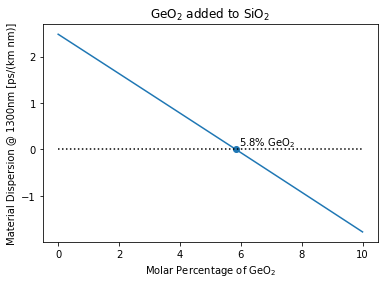

In [3]:
def smfconc(x):
    glass = ofiber.doped_glass(x)
    return  ofiber.Material_Dispersion(glass,1300e-9)   # s/m**2

x = np.linspace(0,0.1,50)
M = np.empty_like(x)
for i in range(len(x)):
    glass = ofiber.doped_glass(x[i])
    M[i]  = ofiber.Material_Dispersion(glass,1300e-9)   # s/m**2
M *= 1e6                                             # ps/(km nm)
plt.plot(x*100,M)
plt.plot([0,10],[0,0],':k')


xx = scipy.optimize.brentq(smfconc,0,0.1)
plt.scatter([xx*100],[smfconc(xx)])
plt.annotate(' %.1f%% GeO$_2$'%(xx*100), xy=(xx*100,0),va='bottom')
plt.xlabel("Molar Percentage of GeO$_2$")
plt.ylabel("Material Dispersion @ 1300nm [ps/(km nm)]")
plt.title('GeO$_2$ added to SiO$_2$')
plt.show()

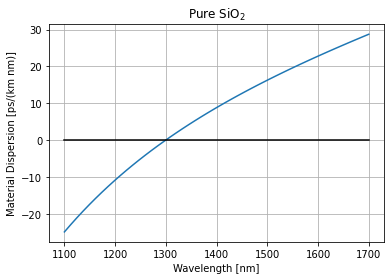

In [4]:
lambda0 = np.linspace(1.1,1.7,50)*1e-6

x = 0.058
glass = ofiber.doped_glass(x)

M  = ofiber.Material_Dispersion(glass,lambda0) # s/m**2
M *= 1e6                                               # ps/(km nm)

plt.plot(lambda0*1e9,M)
plt.plot([1100,1700],[0,0],'k')
plt.xlabel("Wavelength [nm]")
plt.ylabel("Material Dispersion [ps/(km nm)]")
plt.title('Pure SiO$_2$')
plt.grid('on')
plt.show()

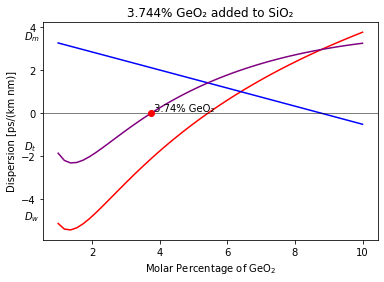

In [38]:
def dt_mixture(x, *args):
    """
    Returns total dispersion for (x)GeO2:(1-x)SiO2 glass 

    wrapper function for use with brentq()
    """
    r_core = args[0]
    λ = args[1]

    cladding = ofiber.doped_glass(0)
    n_clad = ofiber.n(cladding,λ)

    core = ofiber.doped_glass(x)
    n_core = ofiber.n(core, λ)
    
    Dm = ofiber.Material_Dispersion(core, λ)     # s/m**2
    Dw = ofiber.Waveguide_Dispersion(n_core, n_clad, r_core, λ)# s/m**2
    return Dm+Dw

Delta = 0.0036
r_core = 4.1e-6 #m
design_lambda = 1313e-9

x = np.linspace(0.01,0.1,50)
Dm = np.empty_like(x)
Dw = np.empty_like(x)
n_core = np.empty_like(x)

cladding = ofiber.doped_glass(0)
n_clad = ofiber.n(cladding,design_lambda)

for i in range(len(x)):
    core = ofiber.doped_glass(x[i])
    n_core[i] = ofiber.n(core, design_lambda)
    Dm[i] = ofiber.Material_Dispersion(core, design_lambda)     # s/m**2
    Dw[i] = ofiber.Waveguide_Dispersion(n_core[i], n_clad, r_core, design_lambda)# s/m**2
    
Dm *= 1e6                                                        # ps/(km nm)
Dw *= 1e6                                                        # ps/(km nm)

# plot waveguide, material, and total dispersion
plt.plot(x*100, Dw, 'r')
plt.text(0, Dw[0], '$D_w$', va='bottom')

plt.plot(x*100, Dm, 'b')
plt.text(0, Dm[0], '$D_m$', va='bottom')

plt.plot(x*100, Dm+Dw, 'purple')
plt.text(0, Dw[0]+Dm[0], '$D_t$', va='bottom')

plt.axhline(0, color='black', lw=0.5)

# find and label the zero dispersion concentration
xx = scipy.optimize.brentq(dt_mixture,0.015,0.1,args=(r_core, design_lambda))
Dtxx = dt_mixture(xx,r_core,design_lambda)

plt.plot([xx*100],[Dtxx],'or')
plt.annotate(' %.2f%% GeO₂'%(xx*100), xy=(xx*100,Dtxx),va='bottom')

plt.xlabel("Molar Percentage of GeO$_2$")
plt.ylabel("Dispersion [ps/(km nm)]")
plt.title('%.3f%% GeO₂ added to SiO₂' % (xx*100))
plt.show()

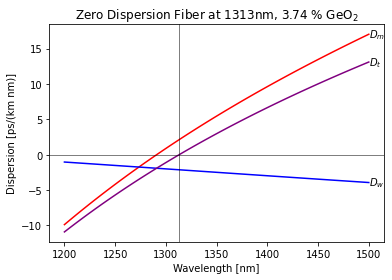

In [45]:
r_core=4.1e-6
x = 0.03744

λ = np.linspace(1.2,1.5,50)*1e-6
core = ofiber.doped_glass(x)
clad = ofiber.doped_glass(0)
n_core = ofiber.n(core, λ)
n_clad = ofiber.n(clad, λ)



Dm = ofiber.Material_Dispersion(core, λ)      # s/m**2
Dw = ofiber.Waveguide_Dispersion(n_core, n_clad, r_core, λ) # s/m**2

Dm *= 1e6                                              # ps/(km nm)
Dw *= 1e6                                              # ps/(km nm)
Dt = Dm+Dw

plt.plot(λ*1e9, Dm, 'r')
plt.plot(λ*1e9, Dw, 'b')
plt.plot(λ*1e9, Dt, 'purple')

plt.text(1500, Dw[-1], '$D_w$', va='center')
plt.text(1500, Dm[-1], '$D_m$', va='center')
plt.text(1500, Dw[-1]+Dm[-1], '$D_t$', va='center')

plt.axhline(0, color='black', lw=0.5)
plt.axvline(1313, color='black', lw=0.5)

plt.xlabel("Wavelength [nm]")
plt.ylabel("Dispersion [ps/(km nm)]")
plt.title('Zero Dispersion Fiber at 1313nm, %.2f %% GeO$_2$'%(x*100))
plt.show()